<a href="https://colab.research.google.com/github/VasudhaMurthy/CNS-Demo/blob/main/garbage_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1: environment + TF + GPU check + list input dirs
!pip install -q tensorflow==2.12.0

import os, sys, shutil
import tensorflow as tf
print("Python:", sys.version.splitlines()[0])
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

print("\nListing /content (top):")
print(os.listdir("/content")[:200])

# Kaggle-specific listing (if running in Kaggle)
if os.path.exists("/kaggle/input"):
    print("\nListing /kaggle/input (top):")
    print(os.listdir("/kaggle/input")[:200])


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TF version: 2.19.0
GPU available: []

Listing /content (top):
['.config', 'sample_data']

Listing /kaggle/input (top):
[]


In [3]:
# CELL 2: prepare dataset location and print a small directory tree
import zipfile, random, textwrap
ROOTS = ["/content/dataset", "/kaggle/working/dataset", "/kaggle/working", "/content"]
# Prefer /content/dataset for Colab; /kaggle/working/dataset for Kaggle
OUT = "/content/dataset"

# If there's a zip in /content, extract to OUT. If running in Kaggle and dataset attached, copy there.
def find_zip_in(path):
    return [f for f in os.listdir(path) if f.lower().endswith(".zip")]

# Try unzip in /content first
unzipped = False
if os.path.exists("/content"):
    zips = find_zip_in("/content")
    if zips:
        print("Found zip(s) in /content:", zips)
        if os.path.exists(OUT):
            shutil.rmtree(OUT)
        os.makedirs(OUT, exist_ok=True)
        for z in zips:
            print("Extracting", z, "->", OUT)
            with zipfile.ZipFile(os.path.join("/content", z),"r") as archive:
                archive.extractall(OUT)
        unzipped = True

# If not found and running on Kaggle, try to copy from /kaggle/input
if not unzipped and os.path.exists("/kaggle/input"):
    # find a candidate folder under /kaggle/input that has images or zips
    import os
    candidate = None
    for name in os.listdir("/kaggle/input"):
        p = os.path.join("/kaggle/input", name)
        # quick check for images or zip inside
        found = False
        for root, dirs, files in os.walk(p):
            if any(f.lower().endswith((".jpg",".jpeg",".png",".zip")) for f in files):
                found = True
                break
        if found:
            candidate = p
            break
    if candidate:
        print("Copying dataset from", candidate, "->", OUT)
        if os.path.exists(OUT): shutil.rmtree(OUT)
        shutil.copytree(candidate, OUT)
        unzipped = True

if not unzipped:
    print("No zip detected and no dataset copied. Make sure your zip is uploaded in Colab Files or dataset is attached in Kaggle.")
else:
    print("Dataset prepared at:", OUT)

# Print a small tree function
def print_tree(root, max_depth=3, prefix=""):
    if max_depth < 0: return
    try:
        entries = sorted(os.listdir(root))
    except Exception as e:
        print(prefix + "[error reading " + root + "]: " + str(e))
        return
    for i, name in enumerate(entries):
        path = os.path.join(root, name)
        connector = "└── " if i==len(entries)-1 else "├── "
        print(prefix + connector + name + ("/" if os.path.isdir(path) else ""))
        if os.path.isdir(path):
            next_pref = prefix + ("    " if i==len(entries)-1 else "│   ")
            print_tree(path, max_depth-1, next_pref)

print("\nTop-level tree of dataset (first 3 levels):")
if os.path.exists(OUT):
    print_tree(OUT, max_depth=3)
else:
    print("Dataset folder not present:", OUT)


Streaming output truncated to the last 5000 lines.
    │   ├── paper385.jpg
    │   ├── paper386.jpg
    │   ├── paper387.jpg
    │   ├── paper388.jpg
    │   ├── paper389.jpg
    │   ├── paper39.jpg
    │   ├── paper390.jpg
    │   ├── paper391.jpg
    │   ├── paper392.jpg
    │   ├── paper393.jpg
    │   ├── paper394.jpg
    │   ├── paper395.jpg
    │   ├── paper396.jpg
    │   ├── paper397.jpg
    │   ├── paper398.jpg
    │   ├── paper399.jpg
    │   ├── paper4.jpg
    │   ├── paper40.jpg
    │   ├── paper400.jpg
    │   ├── paper401.jpg
    │   ├── paper402.jpg
    │   ├── paper403.jpg
    │   ├── paper404.jpg
    │   ├── paper405.jpg
    │   ├── paper406.jpg
    │   ├── paper407.jpg
    │   ├── paper408.jpg
    │   ├── paper409.jpg
    │   ├── paper41.jpg
    │   ├── paper410.jpg
    │   ├── paper411.jpg
    │   ├── paper412.jpg
    │   ├── paper413.jpg
    │   ├── paper414.jpg
    │   ├── paper415.jpg
    │   ├── paper416.jpg
    │   ├── paper417.jpg
    │   ├── paper418.jpg
    

In [4]:
# CELL 3: detect class-folder structure and create processed_train/val if needed
import os, shutil, random, math
ROOT = "/content/dataset"
def looks_like_class_folders(path):
    try:
        subs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path,d))]
    except:
        return False
    if len(subs) < 2: return False
    exts = (".jpg",".jpeg",".png",".bmp")
    has = 0
    for s in subs:
        files = os.listdir(os.path.join(path,s))
        if any(f.lower().endswith(exts) for f in files):
            has += 1
    return has >= 2

if not os.path.exists(ROOT):
    raise FileNotFoundError(f"{ROOT} not found. Re-run upload/unzip step or change ROOT to the correct path.")

# Try common patterns
SOURCE_TRAIN = None
SOURCE_VAL = None

for name in ("train","training"):
    p = os.path.join(ROOT, name)
    if os.path.isdir(p) and looks_like_class_folders(p):
        SOURCE_TRAIN = p
for name in ("test","val","validation"):
    p = os.path.join(ROOT, name)
    if os.path.isdir(p) and looks_like_class_folders(p):
        SOURCE_VAL = p

if SOURCE_TRAIN is None:
    # find a candidate under ROOT
    candidates = []
    for item in os.listdir(ROOT):
        p = os.path.join(ROOT, item)
        if os.path.isdir(p) and looks_like_class_folders(p):
            candidates.append(p)
    if candidates:
        SOURCE = candidates[0]
        print("Creating 80/20 split from:", SOURCE)
        processed_train = "/content/processed_train"
        processed_val   = "/content/processed_val"
        if os.path.exists(processed_train): shutil.rmtree(processed_train)
        if os.path.exists(processed_val): shutil.rmtree(processed_val)
        os.makedirs(processed_train, exist_ok=True)
        os.makedirs(processed_val, exist_ok=True)
        split_ratio = 0.8
        for cls in sorted(os.listdir(SOURCE)):
            src_cls = os.path.join(SOURCE, cls)
            if not os.path.isdir(src_cls): continue
            imgs = [f for f in os.listdir(src_cls) if f.lower().endswith((".jpg",".jpeg",".png"))]
            if len(imgs) == 0:
                print("Warning: class folder has no images:", src_cls)
                continue
            random.shuffle(imgs)
            cut = max(1, int(len(imgs)*split_ratio))
            os.makedirs(os.path.join(processed_train, cls), exist_ok=True)
            os.makedirs(os.path.join(processed_val, cls), exist_ok=True)
            for f in imgs[:cut]:
                shutil.copy(os.path.join(src_cls,f), os.path.join(processed_train, cls, f))
            for f in imgs[cut:]:
                shutil.copy(os.path.join(src_cls,f), os.path.join(processed_val, cls, f))
        SOURCE_TRAIN = processed_train
        SOURCE_VAL   = processed_val
    else:
        # look for CSV label file
        csvs = []
        for root, dirs, files in os.walk(ROOT):
            for f in files:
                if f.lower().endswith(".csv"):
                    csvs.append(os.path.join(root,f))
        if csvs:
            print("Found CSV(s):", csvs)
            raise Exception("Dataset uses CSV labels. Tell me CSV path and layout OR reorganize into class folders.")
        else:
            raise Exception("No class-folder structure detected under dataset root. Inspect printed tree.")

print("Final train folder:", SOURCE_TRAIN)
print("Final val folder:  ", SOURCE_VAL)
print("Classes (train):", sorted([d for d in os.listdir(SOURCE_TRAIN) if os.path.isdir(os.path.join(SOURCE_TRAIN,d))]))


Creating 80/20 split from: /content/dataset/garbage_classification
Final train folder: /content/processed_train
Final val folder:   /content/processed_val
Classes (train): ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


Creating train dataset from: /content/processed_train
Found 12409 files belonging to 12 classes.
Found 3106 files belonging to 12 classes.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']   Num classes: 12
Train batches (one):
 batch images shape: (16, 224, 224, 3)  dtype: <dtype: 'float32'>
 batch labels: [ 4  9  4  4  0  4  4  4  4  4  4 11  4  9  0  4]


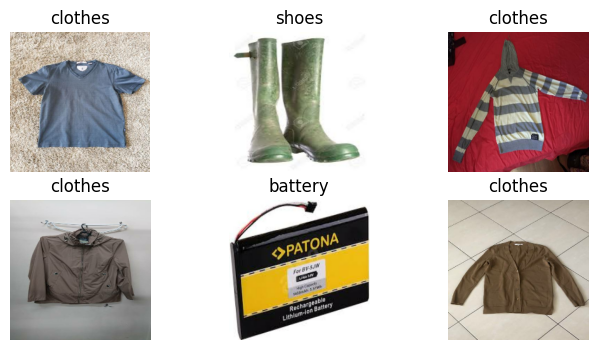

In [5]:
# CELL 4: create tf.data pipelines and show a small batch for visual verification
import tensorflow as tf
from tensorflow.keras import layers, models
IMG_SIZE = (224,224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

print("Creating train dataset from:", SOURCE_TRAIN)
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        SOURCE_TRAIN, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=42
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        SOURCE_VAL, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
    )
except Exception as e:
    print("ERROR while creating image_dataset_from_directory:", e)
    raise

print("Classes:", train_ds.class_names, "  Num classes:", len(train_ds.class_names))
print("Train batches (one):")
for images, labels in train_ds.take(1):
    print(" batch images shape:", images.shape, " dtype:", images.dtype)
    print(" batch labels:", labels.numpy())
    break

# quick visualization (optional) - comment out if on headless runner
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    for i in range(min(6, images.shape[0])):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(train_ds.class_names[int(labels[i])])
        plt.axis("off")
    plt.show()
except Exception as viz_e:
    print("Visualization skipped or failed:", viz_e)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [7]:
# FIXED CELL 5 - use filesystem to get class names, then train tiny model for 1 epoch
import os
from tensorflow.keras import layers, models

# Get class names from the train folder so we don't rely on dataset.class_names
class_names = sorted([d for d in os.listdir(SOURCE_TRAIN) if os.path.isdir(os.path.join(SOURCE_TRAIN, d))])
num_classes = len(class_names)
print("Detected classes (count):", num_classes)
print(class_names)

def build_tiny_model(input_shape=(224,224,3), num_classes=2):
    inp = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inp)
    x = layers.Conv2D(16,3,activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(32,3,activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model = build_tiny_model(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
model.summary()

print("Training for 1 epoch (quick test)...")
try:
    history = model.fit(train_ds, validation_data=val_ds, epochs=1)
    print("Training completed.")
except Exception as e:
    print("Training FAILED:", e)
    raise


Detected classes (count): 12
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,484 (21.42 KB)

 Trainable params: 5,484 (21.42 KB)

 Non-trainable params: 0 (0.00 B)

Training for 1 epoch (quick test)...
776/776 ━━━━━━━━━━━━━━━━━━━━ 503s 645ms/step - accuracy: 0.3489 - loss: 2.0903 - val_accuracy: 0.4636 - val_loss: 1.6821
Training completed.


In [14]:
# FIXED CELL 6 - save as SavedModel (compatible) and convert to TFLite with robust error handling
import os, shutil, tensorflow as tf

SAVED = "/content/saved_model_debug"
if os.path.exists(SAVED):
    shutil.rmtree(SAVED)

# Export SavedModel in a way compatible across TF/Keras versions
try:
    # Prefer model.export() when available (Keras 3)
    if hasattr(model, "export"):
        print("Using model.export() to write SavedModel...")
        model.export(SAVED)
    else:
        print("Using tf.saved_model.save() to write SavedModel...")
        tf.saved_model.save(model, SAVED)
    print("Saved model to:", SAVED)
except Exception as e:
    print("Failed to save/export SavedModel:", type(e).__name__, e)
    raise

def file_size_mb(path):
    return os.path.getsize(path)/1e6 if os.path.exists(path) else 0.0

# Float32 conversion
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED)
    tflite_model = converter.convert()
    tpath = "/content/garbage_model_debug_float32.tflite"
    with open(tpath, "wb") as f: f.write(tflite_model)
    print("Float32 tflite written:", tpath, " size (MB):", file_size_mb(tpath))
except Exception as e:
    print("Float32 conversion FAILED:", type(e).__name__, e)

# Dynamic range quant conversion
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant = converter.convert()
    qpath = "/content/garbage_model_debug_dynamic_quant.tflite"
    with open(qpath, "wb") as f: f.write(tflite_quant)
    print("Dynamic-quant tflite written:", qpath, " size (MB):", file_size_mb(qpath))
except Exception as e:
    print("Dynamic quant conversion FAILED:", type(e).__name__, e)

# Print produced files
print("\nProduced files and sizes (MB):")
for p in ["/content/garbage_model_debug_float32.tflite", "/content/garbage_model_debug_dynamic_quant.tflite"]:
    if os.path.exists(p):
        print(" -", p, ":", file_size_mb(p))
    else:
        print(" -", p, ": NOT FOUND")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 43.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


ModuleNotFoundError: No module named 'tflite_model_maker'

In [11]:
# FIXED CELL 7 - integer quant (robust) with proper file-size and full traceback on error
import os, tensorflow as tf, traceback

def rep_gen():
    for images, _ in train_ds.take(100):
        yield [tf.cast(images, tf.float32)]

try:
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = rep_gen
    # allow fallback ops for robustness
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
        tf.lite.OpsSet.TFLITE_BUILTINS
    ]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    tflite_int = converter.convert()
    ipath = "/content/garbage_model_debug_int8.tflite"
    with open(ipath, "wb") as f:
        f.write(tflite_int)
    print("Int8 tflite written:", ipath, " size (MB):", os.path.getsize(ipath)/1e6)
except Exception as e:
    print("Int8 conversion FAILED:", type(e).__name__, e)
    traceback.print_exc()


Int8 tflite written: /content/garbage_model_debug_int8.tflite  size (MB): 0.010936


In [12]:
# CELL 8: list created files and sizes; print helpful next steps
import glob, os
print("\nTFLite files in /content:")
for p in glob.glob("/content/*tflite"):
    print(" -", p, " size (MB):", os.path.getsize(p)/1e6)

print("\nIf any cell failed, copy the entire error trace and paste it here.\nCommon issues and tips:")
print(textwrap.dedent("""
- FileNotFoundError: Wrong path. Re-check the dataset location printed in CELL 2.
- image_dataset_from_directory error: dataset not organized as class folders. If you have a CSV mapping, tell me CSV path and format.
- OOM (out-of-memory) during training: reduce BATCH_SIZE, use smaller IMG_SIZE (e.g., 128), or use the tiny model (we used it by default).
- TFLite conversion error: paste the converter exception; I will interpret it and give a fix (common fixes: unsupported ops, set converter.target_spec.supported_ops, or remove full-int8 constraints).
- If MobileNet weights failed to download: check internet or use CPU environment.
"""))



TFLite files in /content:
 - /content/garbage_model_debug_float32.tflite  size (MB): 0.02504
 - /content/garbage_model_debug_dynamic_quant.tflite  size (MB): 0.011504
 - /content/garbage_model_debug_int8.tflite  size (MB): 0.010936

If any cell failed, copy the entire error trace and paste it here.
Common issues and tips:

- FileNotFoundError: Wrong path. Re-check the dataset location printed in CELL 2.
- image_dataset_from_directory error: dataset not organized as class folders. If you have a CSV mapping, tell me CSV path and format.
- OOM (out-of-memory) during training: reduce BATCH_SIZE, use smaller IMG_SIZE (e.g., 128), or use the tiny model (we used it by default).
- TFLite conversion error: paste the converter exception; I will interpret it and give a fix (common fixes: unsupported ops, set converter.target_spec.supported_ops, or remove full-int8 constraints).
- If MobileNet weights failed to download: check internet or use CPU environment.



In [13]:
from google.colab import files
files.download("/content/garbage_model_debug_dynamic_quant.tflite")  # recommended
# files.download("/content/garbage_model_debug_float32.tflite")
# files.download("/content/garbage_model_debug_int8.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>